# **Using Physical Attributes and Point Perctanges to Predict Position for NBA Players**

##### *Tanisha Amrin, Charmaine Chui, Jakob Sereda, Julian Wright*

## **Introduction**

One of the most popular sports in North America and worldwide (*SportsPro Media*, 2023), games of basketball have been played amongst millions, both professional and amateur, since its invention in 1891 (*National Geographic*, 2021). When it comes to professional basketball, all eyes are on the National Basketball Association (or NBA), which is considered to be the premier professional basketball league in the world (*SportsPro Media*, 2023). 

A key aspect of basketball are the positions of the players. Although there are many roles officially documented, they can be grouped into the three main categories of centers, forwards, and guards (*Under Armour*). The nuances of these roles can have a profound impact on a team's ability to perform, allowing individual players to show their unique talents if placed in the right role (*RedBull*, 2022). 

The question we seek to answer is: **What position is a player most likely to play, given their height, weight, free-throw percentage, and field goal percentage?**

The data set we will use to answer this question was pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA, using the NBA API Client package; [*github.com/swar/nba_api*](https://github.com/swar/nba_api)  (Swar Patel, Randall Forbes, et al). It contains stats on individual players during each NBA season. There are 58 columns and 4,917 rows in this data set, missing values are represented by "NA". We provide descriptions of the following columns from the data relevant to our analysis below:
- **PERSON_ID:** the given player's id
- **HEIGHT:** player's height in inches
- **WEIGHT:** player's weight in lbs
- **POSITION:** player's position
- **FG_PCT:** field goal percentage (field goals made / field goals attempted)
- **FT_PCT:** free throw percentage (free throws made / free throws attempted)

## **Preliminary Exploratory Data Analysis**

In [63]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

In [90]:
set.seed(2024) 

# reading in the data from the web
nba_data <- read_csv("https://raw.githubusercontent.com/jakobsereda/dsci-100-project/main/stats.csv", show_col_types = FALSE) 

# cleaning and wrangling the data
names(nba_data) <- tolower(names(nba_data))

nba_clean <- nba_data |>
    select(person_id, first_name, last_name, height, weight, position, season_id, 
           gp, gs, min, fg_pct, fg3_pct, ft_pct, reb, ast, stl, blk, tov, pf, pts) |>
    na.omit() |>
    mutate(position = ifelse(position == "Center-Forward", "Center", position)) |>
    mutate(position = ifelse(position == "Guard-Forward", "Guard", position)) |>
    mutate(position = ifelse(position == "Forward-Guard" | position == "Forward-Center", "Forward", position)) |>
    mutate(position = as_factor(position))

# splitting the data into training and testing sets
nba_split <- initial_split(nba_clean, prop = 3/4, strata = position)

nba_train <- training(nba_split)
nba_test <- testing(nba_split)

head(nba_train)

person_id,first_name,last_name,height,weight,position,season_id,gp,gs,min,fg_pct,fg3_pct,ft_pct,reb,ast,stl,blk,tov,pf,pts
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76003,Kareem,Abdul-Jabbar,86,225,Center,1988-89,74,74,1695,0.475,0.000,0.739,334,74,38,85,95,196,748
201582,Alexis,Ajinca,86,248,Center,2016-17,39,15,584,0.500,0.000,0.725,177,12,20,22,31,77,207
202374,Solomon,Alabi,85,252,Center,2011-12,14,0,122,0.361,0.000,0.875,47,3,2,9,5,11,33
202332,Cole,Aldrich,83,253,Center,2017-18,21,0,49,0.333,0.000,0.333,15,3,2,1,1,11,12
200746,LaMarcus,Aldridge,83,250,Center,2021-22,47,12,1050,0.550,0.304,0.873,258,42,14,47,44,78,607
76021,Chuck,Aleksinas,83,260,Center,1984-85,74,4,1114,0.478,0.000,0.733,270,36,15,15,72,171,377


In [91]:
# summarizing the number of players in each position, and the min, max, and mean of each predictor for each position
nba_summarized <- nba_train |>
    group_by(position) |>
    summarize(min_height = min(height), max_height = max(height), mean_height = mean(height),
              min_weight = min(weight), max_weight = max(weight), mean_weight = mean(weight),
              min_fg_pct = min(fg_pct), max_fg_pct = max(fg_pct), mean_fg_pct = mean(fg_pct),
              min_ft_pct = min(ft_pct), max_ft_pct = max(ft_pct), mean_ft_pct = mean(ft_pct),
              n_players = n())

nba_summarized

position,min_height,max_height,mean_height,min_weight,max_weight,mean_weight,min_fg_pct,max_fg_pct,mean_fg_pct,min_ft_pct,max_ft_pct,mean_ft_pct,n_players
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Forward,71,86,80.11799,153,289,226.2340,0,1,0.4092183,0,1,0.6031200,1017
Center,79,91,83.36118,195,360,250.5577,0,1,0.4317838,0,1,0.5567199,407
Guard,65,84,75.56789,133,255,194.8569,0,1,0.3732541,0,1,0.6561018,1090


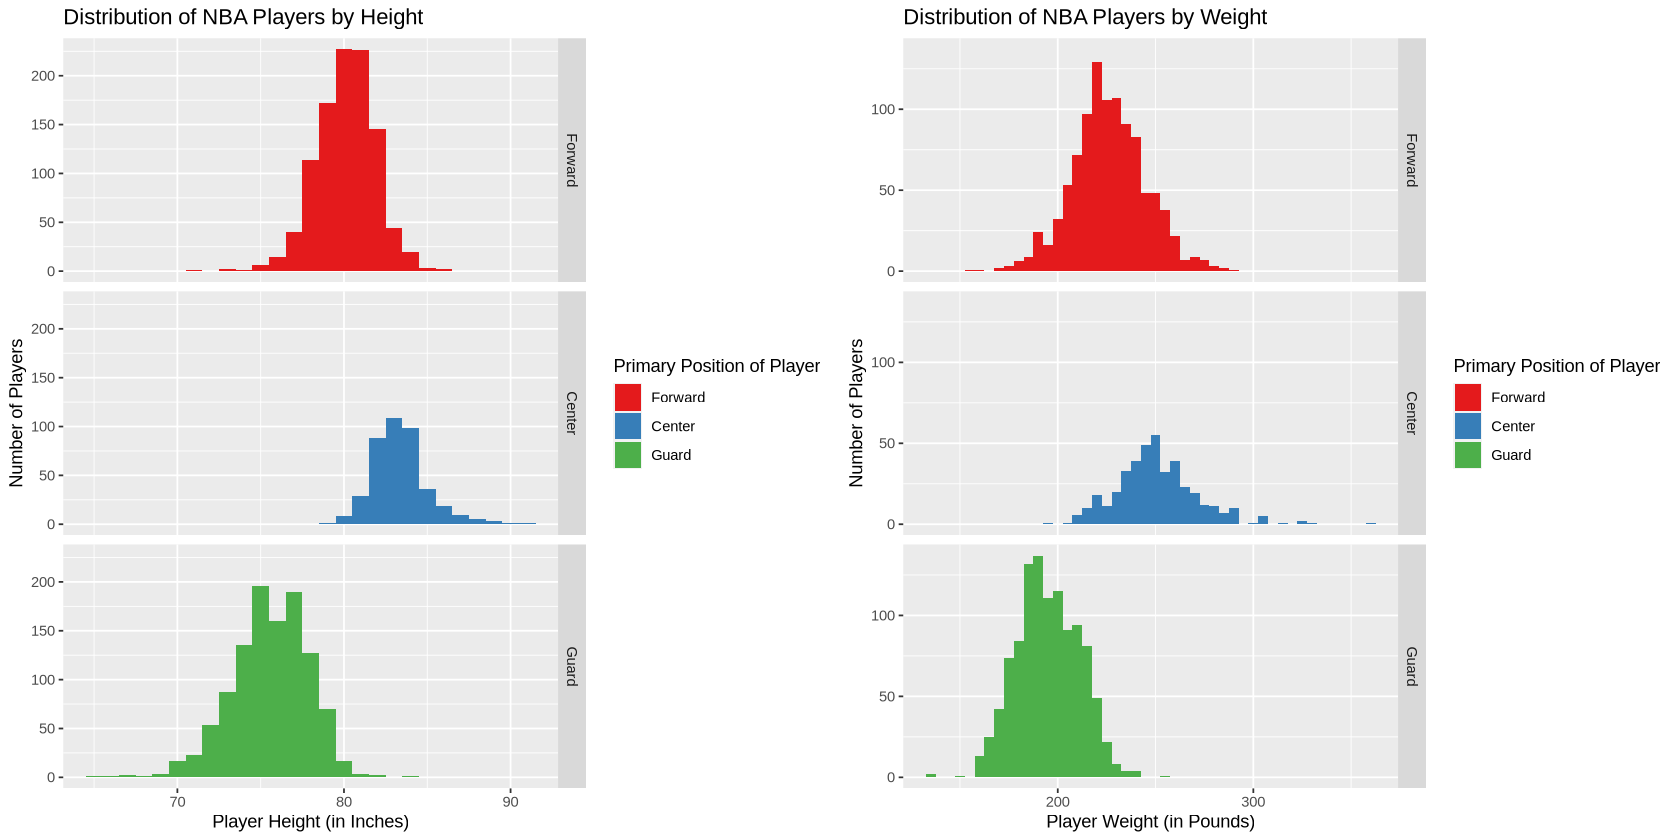

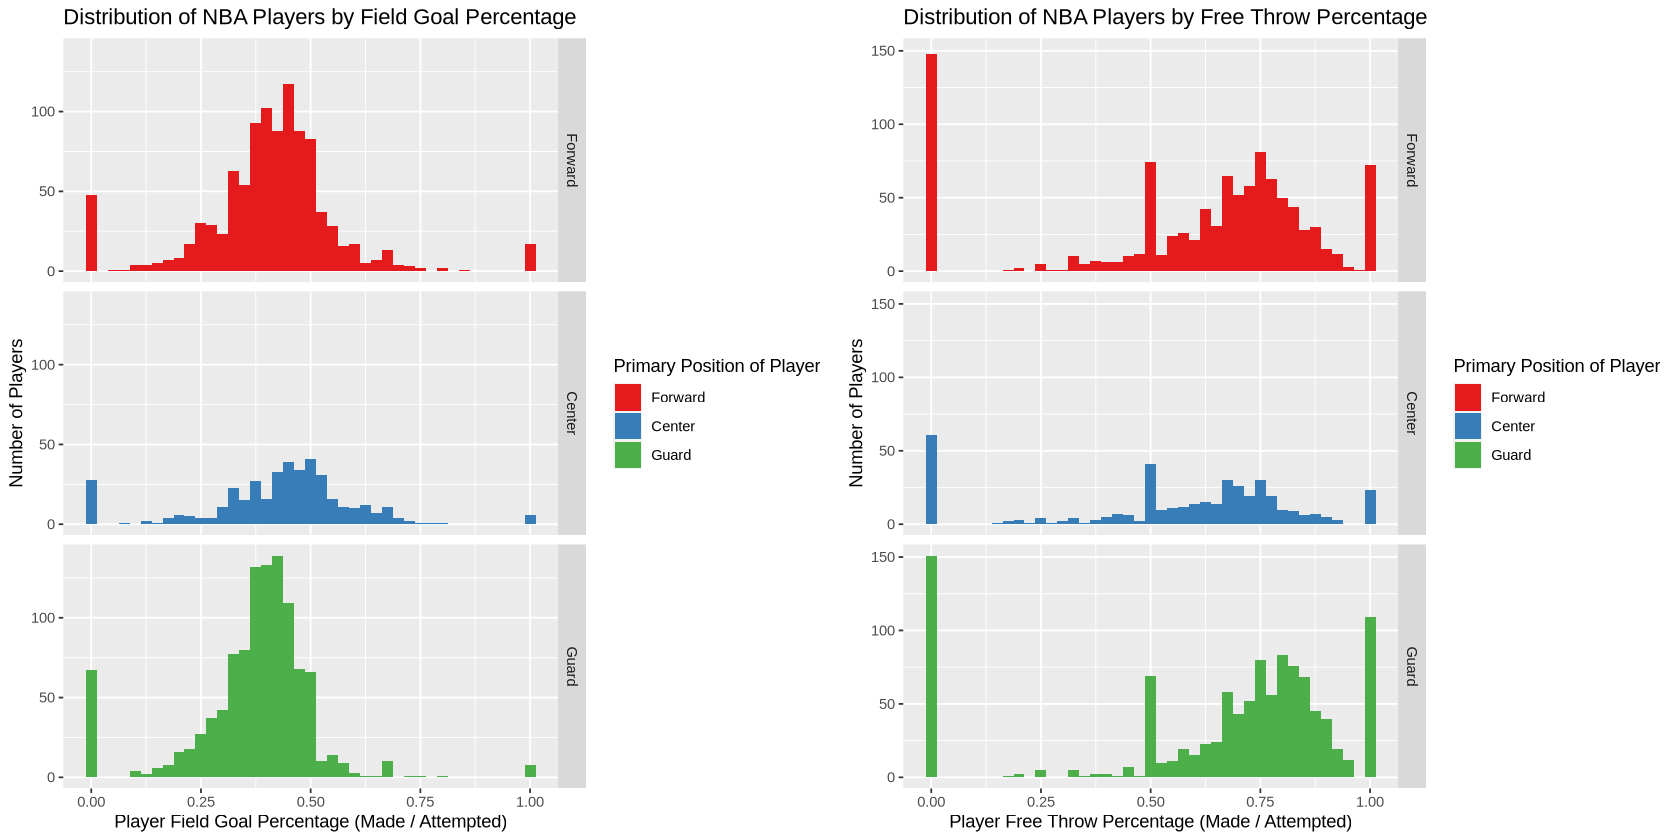

In [97]:
options(repr.plot.width = 14, repr.plot.height = 7)

# plotting the distributions of the predictors for each position (using training data)
nba_plot_height <- nba_train |>
    ggplot(aes(x = height, fill = position)) +
        geom_histogram(binwidth = 1) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Height (in Inches)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Height") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_weight <- nba_train |>
    ggplot(aes(x = weight, fill = position)) +
        geom_histogram(binwidth = 5) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Weight (in Pounds)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Weight") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_fg_pct <- nba_train |>
    ggplot(aes(x = fg_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Field Goal Percentage (Made / Attempted)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Field Goal Percentage") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_ft_pct <- nba_train |>
    ggplot(aes(x = ft_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Free Throw Percentage (Made / Attempted)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Free Throw Percentage") +
        scale_fill_brewer(palette = 'Set1')

grid.arrange(nba_plot_height, nba_plot_weight, ncol = 2)
grid.arrange(nba_plot_fg_pct, nba_plot_ft_pct, ncol = 2)

## **Methods**

To clean our data we first changed all of the column names to lowercase, selected only the columns with unique and relevant data, and removed all NA's in the dataset. We then mutated the data such that each player was labeled by their *primary position*, given by the position before the hyphen if they were labeled with a hybrid role, and changed the **position** column to type factor.

We then split our data into testing and training sets using *initial_split*, with 3/4 of the data becoming our training set and the rest being reserved for testing.

To create a summary table of our data, we grouped by **position** and then summarized the min, max, and mean of each predictor, as well as the count of players for each position.

To visualize our results, we created histograms displaying the distribution of **height**, **weight**, **fg_pct**, and **ft_pct** for each **position**. We observed different curves for both **height** and **weight** depending on **position**, confirming our original prediction that they would be good predictors. Additionally, we recognized some very slight, and surprisingly small differences for both **fg_pct** and **ft_pct**. We had hoped these differences would be more noticeable, but still feel they are significant enough for these predictors to be helpful in combination with **height** and **weight**.

Ultimately, we decided to make **height**, **weight**, **fg_pct**, and **ft_pct** our predictors for the **position**. We also decided that we would use these predictors to create a **k-nn** model.

## **Expected Outcome and Significance**

We expect to find that:
- Players classified as **Centers** will, on average, tend to be taller, weigh more, have higher field goal percentages, and lower free throw percentages
- Players classified as **Guards** will, on average, tend to be shorter, weigh less, have lower field goal percentages, and higher free throw percentages
- Players classified as **Forwards** will, on average, tend to split the difference between the observed stats for Centers and Guards

These findings could be beneficial in managing a lineup for NBA teams. They will allow managers to maximize the overall performance of the team through positioning. An increase in the overall performance of the team allows the team to have a better win rate, seasonal record, and even qualify for the playoffs.

One subsequent question these findings could lead to is whether the performance of an NBA team depends more on hard stats and positioning, or emotional connection and chemistry. Another question this analysis could lead to is which factor most influences the position a player is most likely to fit (physical characteristics or point percentages).

## **Bibliography**

- Data is pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA, 
   using the NBA API Client package; [*github.com/swar/nba_api*](https://github.com/swar/nba_api) (Swar Patel, Randall Forbes, et al). *Note: this dataset was not provided on Canvas, but was approved by a TA during tutorial.*
- McMurray, Ben. "Why the NBA is America's Most Globally Relevant Sports Property." *SportsPro Media*, 24 Oct. 2023, [*link*](https://www.sportspromedia.com/insights/analysis/nba-tv-rights-revenue-global-popularity-data-ampere-analysis/).
- Toole, T.C. "Here's the History of Basketball - From Peach Baskets in Springfield to Global Phenomenon." *National Geographic*, 27 Mar. 2021, [*link*](https://www.nationalgeographic.com/history/article/basketball-only-major-sport-invented-united-states-how-it-was-created).
- "What are the 5 Basketball Positions and Their Roles?", *Under Armour*, [*link*](https://www.underarmour.com/en-us/t/playbooks/basketball/basketball-positions/).
- Lister, Aimee. "Basketball Positions Explained: What Each Player Does." *RedBull*, 21 Jul. 2022, [*link*](https://www.redbull.com/us-en/basketball-positions-what-each-player-does#:~:text=Generally%20speaking%2C%20each%20team%20is,handling%2C%20passing%20and%20shooting%20skills.).